# Computing error bars

__Goal__: investigate different possibilities to estimate error bars of statistics from a single set of samples.

In [27]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(""), "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from tqdm import tqdm
from matplotlib.colors import LogNorm

from infovar.stats import entropy_estimators as ee

# plt.rc("text", usetex=True)

## Introduction

L'estimation d'une statistique, par exemple l'entropie, d'une variable aléatoire est sujette à une uncertitude provenant de deux sources:
- la variance et le biais de l'estimateur
- les fluctuations statistiques i.e. les différences entre plusieurs échantillonnages d'une même distributions

Lorsque l'on possède un unique ensemble d'échantillon, le calcul de cette uncertitude n'est pas aisé. Il existe cependant plusieurs approches permettant d'estimer cette uncertitude, et notamment les deux méthodes suivantes:
- le bootstrapping, un ré-échantillonnage avec remplacement du jeu de données
- le sous-échantillonnage avec optimisation d'un modèle

In [28]:
# Choose whether you want a bivariate normal or lognormal distribution
lognorm = False

### Datasets

In [29]:
rho = 0.8
sigmax, sigmay = 2, 1
N = 10_000

def get_data(n: int) -> np.ndarray:
    mus = np.array([0, 0])
    sigmas = np.array([[sigmax**2, sigmax*sigmay*rho], [sigmax*sigmay*rho, sigmay**2]])

    data = np.random.multivariate_normal(mus, sigmas, size=n)
    if lognorm:
        data = np.exp(data)
    return data

data = get_data(N)

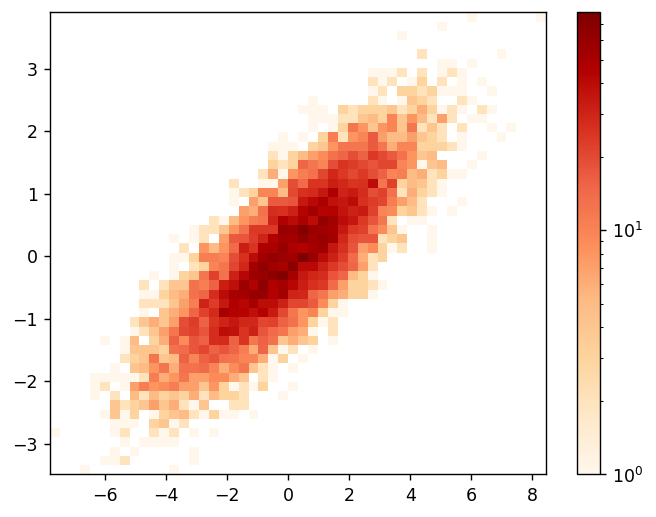

In [30]:
plt.figure(dpi=125)

_range = None if not lognorm else ((0, np.percentile(data[:, 0], 90)), (0, np.percentile(data[:, 1], 90)))
plt.hist2d(data[:, 0], data[:, 1], bins=50, cmap="OrRd", norm=LogNorm(), range=_range)
plt.colorbar()

plt.show()

In [31]:
range

range

## Bootstrapping

In [32]:
# TODO

### Degeneracy induced by bootstrapping

In [33]:
n = 10_000
iters = 10_000

# Empirical

counts_list = []
max_len = 0
for it in tqdm(range(iters)):
    x = np.random.choice(n, n, replace=True)
    c = np.bincount(np.bincount(x))
    counts_list.append(c)
    if c.size > max_len:
        max_len = c.size
        
for it, counts in enumerate(tqdm(counts_list)):
    counts_list[it] = np.pad(counts, (0, max_len - len(counts)), mode='constant')
    
counts = np.array(counts_list) # shape (iters, n)
freqs = counts / n

# Analytical

probs = np.array([binom.pmf(k, n, 1/n) for k in range(max_len)])

100%|██████████| 10000/10000 [00:00<00:00, 15593.54it/s]


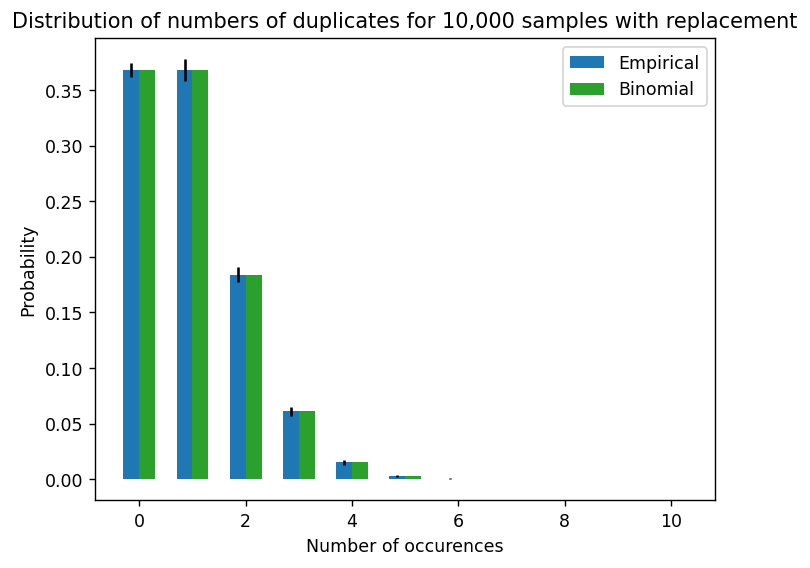

In [34]:
width = 0.3
stds = np.std(freqs, axis=0)

#

plt.figure(dpi=125)

plt.bar(np.arange(max_len) - width/2, np.mean(freqs, axis=0), yerr=2*stds, color='tab:blue', width=width, label='Empirical')
plt.bar(np.arange(max_len) + width/2, probs, color='tab:green', width=width, label='Binomial')

plt.xlabel("Number of occurences")
plt.ylabel("Probability")
plt.title(f"Distribution of numbers of duplicates for {n:,} samples with replacement")
plt.legend()

plt.show()

Ces duplicats ne sont pas un problème lorsque l'on cherche par exemple à estimer la moyenne, ou tout autre statistique dont l'estimation est linéaire aux échantillons.

Cependant, ce n'est pas le cas des estimateurs kNN comme ceux de l'entropie et de l'information mutuelle pour lesquels cela va mener à des valeurs largement faussées. La raison est que des échantillons identiques (ou quasiment identiques si l'on ajoute un léger bruit) créent une densité anormalement élevée (voir infinie) localement.

Pour ces estimateurs, il est alors plus pertinent de suivre une autre approche ne créant pas ce type de doublons.

## Subsampling with model

(Homles & Nemenman, 2019)

$$ \sigma^2(N) = \frac{B}{N} $$

In [112]:
from math import floor
from random import shuffle

nis = np.logspace(1, 2.3, 5).round().astype(int)
nis = np.unique(nis)

Nis = []
sigma2s = []
idx = list(range(N))
for ni in nis:
    Ni = floor(N / ni)
    Nis.append(Ni)
    shuffle(idx)
    _mis = []
    for i in range(ni):
        sidx = idx[i*Ni:(i+1)*Ni]
        _mis.append(ee.mi(
            data[sidx, 0].reshape(-1, 1),
            data[sidx, 1].reshape(-1, 1)
        ))
    sigma2 = np.var(_mis)
    sigma2s.append(sigma2)

nis = np.array(nis)
Nis = np.array(Nis)
sigma2s = np.array(sigma2s)

In [ ]:
nis_true = np.logspace(0, 3, 15).round().astype(int)
nis_true = np.unique(nis_true)
n_iter = 100

Nis_true = []
sigma2s_true = []
for ni in nis_true:
    Ni = floor(N / ni)
    Nis_true.append(Ni)
    _mis = []
    for i in range(n_iter):
        _data = get_data(Ni)
        _mis.append(ee.mi(
            _data[:, 0].reshape(-1, 1),
            _data[:, 1].reshape(-1, 1)
        ))
    sigma2 = np.var(_mis)
    sigma2s_true.append(sigma2)

nis_true = np.array(nis_true)
Nis_true = np.array(Nis_true)
sigma2s_true = np.array(sigma2s_true)

B = N * np.sum((nis-1)/nis * sigma2s) / np.sum(nis - 1)

In [ ]:
plt.figure(figsize=(0.8*6.4, 0.9*4.8), dpi=150)

plt.loglog(1/Nis, sigma2s, linestyle="none", marker="D", color="black", label="Computed with resampling")
plt.loglog(1/Nis_true, B/Nis_true, color="black", label=f"$B = {B:.2f}$")

plt.xlabel("$1/N_i$")
plt.ylabel("Variance of MI", labelpad=5)
plt.legend()

plt.show()

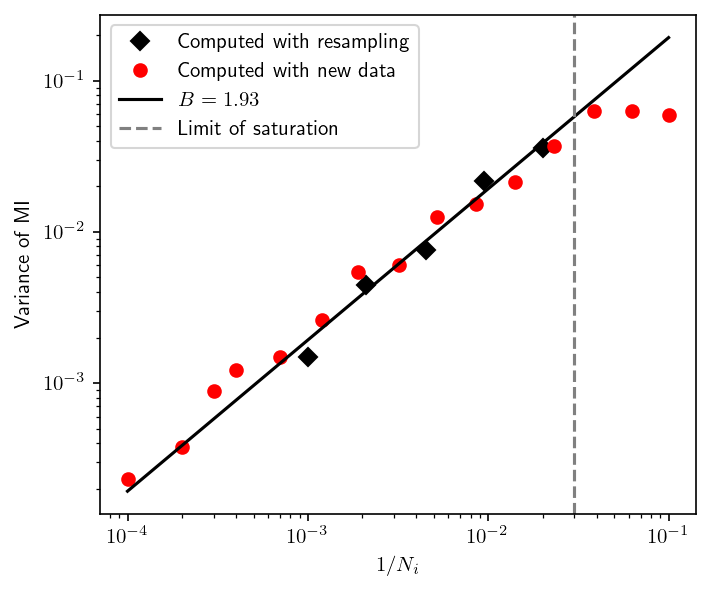

In [115]:
plt.figure(figsize=(0.8*6.4, 0.9*4.8), dpi=150)

plt.loglog(1/Nis, sigma2s, linestyle="none", marker="D", color="black", label="Computed with resampling")
plt.loglog(1/Nis_true, sigma2s_true, linestyle="none", marker="o", color="red", label="Computed with new data")
plt.loglog(1/Nis_true, B/Nis_true, color="black", label=f"$B = {B:.2f}$")
plt.axvline(3e-2, linestyle="--", color="gray", label="Limit of saturation")

plt.xlabel("$1/N_i$")
plt.ylabel("Variance of MI", labelpad=5)
plt.legend()

plt.show()

In [ ]:
def var_mi(newN: float=N) -> float:
    B = N * np.sum((nis-1)/nis * sigma2s) / np.sum(nis - 1)
    return B / newN

### Limitations

Contrairement au bootstrapping, il est nécessaire d'avoir suffisamment d'échantillons pour pouvoir estimer $B$. Or, l'estimation de l'uncertitude est justement critique pour les échantillons de petites tailles.